In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import h5py
import numpy as np
from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.power_analysis import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
verbose = False
agent_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
    
    areas = ['all']
    agent_data[(data_class, agent)] = {'session_list': session_list}

    session_lists, locs, rocs, ropaps = get_session_plot_info(cfg, session_list, verbose=False)

    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['locs'] = locs
    agent_data[(data_class, agent)]['rocs'] = rocs
    agent_data[(data_class, agent)]['ropaps'] = ropaps

    # noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=verbose)
    # agent_data[(data_class, agent)]['noise_filter_info'] = noise_filter_info
    
    # pca_chosen = get_pca_chosen(cfg, session_list, areas, noise_filter_info, verbose=verbose)
    # agent_data[(data_class, agent)]['pca_chosen'] = pca_chosen
    # all_indices_to_run = collect_grid_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    # if all_indices_to_run:
    #     raise ValueError(f"Sessions for agent {agent} have incomplete grid search - cannot continue")
    
    # grid_params_to_use = get_grid_params_to_use(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    # agent_data[(data_class, agent)]['grid_params_to_use'] = grid_params_to_use
    # all_indices_to_run = collect_delase_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, grid_params_to_use, verbose=verbose)
    
    # if all_indices_to_run:
    #     raise ValueError(f"Sessions for agent {agent} have incomplete DeLASE - cannot continue")

    # delase_results = get_delase_results(cfg, session_list, areas, grid_params_to_use, pca_chosen, verbose=verbose)
    # agent_data[(data_class, agent)]['delase_results'] = delase_results

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
area = 'all'
save_dir = "/orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/power_analysis"

In [9]:
top_percent = 0.1

power_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    cfg.params.data_class = data_class
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    power_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        power_info[(data_class, agent)][monkey] = {}
        for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
            power_info[(data_class, agent)][monkey][dose] = {}
            for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
                if not os.path.exists(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl')):
                    raise ValueError(f"Session {session} does not exist")
                else:
                    ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))
                    # freq_powers = ret_dict['freq_powers']
                    freq_r2_scores = ret_dict['freq_r2_scores']
                    power_info[(data_class, agent)][monkey][dose][session] = freq_r2_scores


  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
plot_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    plot_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        plot_info[(data_class, agent)][monkey] = {}
        for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
            plot_info[(data_class, agent)][monkey][dose] = {band: [] for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
            for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
                for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
                    plot_info[(data_class, agent)][monkey][dose][band].append(power_info[(data_class, agent)][monkey][dose][session][band])


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
data_class, agent = anesthetic_agent_list[1]

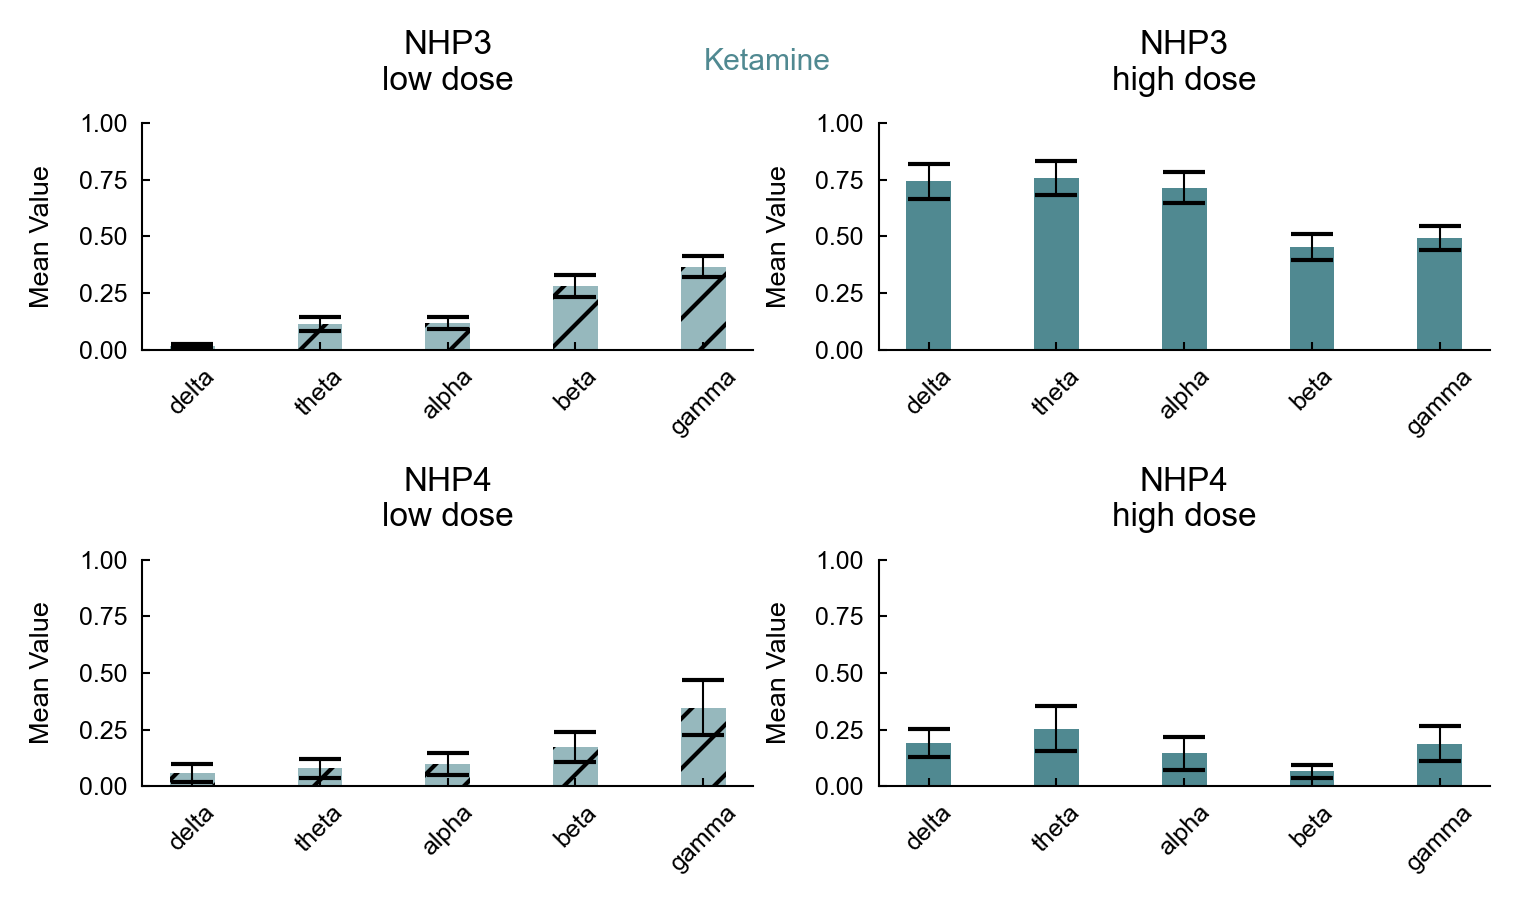

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Set up the plot
# titles = ['SPOCK - Low', 'SPOCK - High', 'PEDRI - Low', 'PEDRI - High']
monkey_titles = {
    'Mary': 'NHP1',
    'MrJones': 'NHP2',
    'SPOCK': 'NHP3',
    'PEDRI': 'NHP4'
}
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
x = np.arange(len(bands))
width = 0.35

# Colors for each frequency band
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
colors = curve_colors[agent]

data_dict = plot_info[(data_class, agent)]

monkeys = list(data_dict.keys())
doses = list(data_dict[monkeys[0]].keys())

if len(doses) > 1:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 3))
    axes = [ax1, ax2, ax3, ax4]
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 1.5))
    axes = [ax1, ax2]

# Process and plot data for each monkey/dose combination
for idx, (monkey, dose) in enumerate(itertools.product(monkeys, doses)):
    means = []
    sems = []
    
    # Calculate mean and SEM for each frequency band
    for band in bands:
        data = data_dict[monkey][dose][band]
        mean = np.mean(data)
        sem = np.std(data) / np.sqrt(len(data))
        means.append(mean)
        sems.append(sem)
    
    # Create the bar plot
    ax = axes[idx]
    if dose == 'low':
        bars = ax.bar(x, means, width, yerr=sems, capsize=5, color=colors, alpha=0.6, hatch='//')
    else:
        bars = ax.bar(x, means, width, yerr=sems, capsize=5, color=colors)
    
    # Customize the plot
    ax.set_ylabel('Mean Value')
    ax.set_title(f"{monkey_titles[monkey]}\n{dose} dose")
    ax.set_xticks(x)
    ax.set_xticklabels(bands, rotation=45)
    ax.set_ylim(0, 1)

# Adjust layout and display
plt.tight_layout()
fig.suptitle(f'{agent.capitalize()}', c=curve_colors[agent], y=0.95)
plt.show()

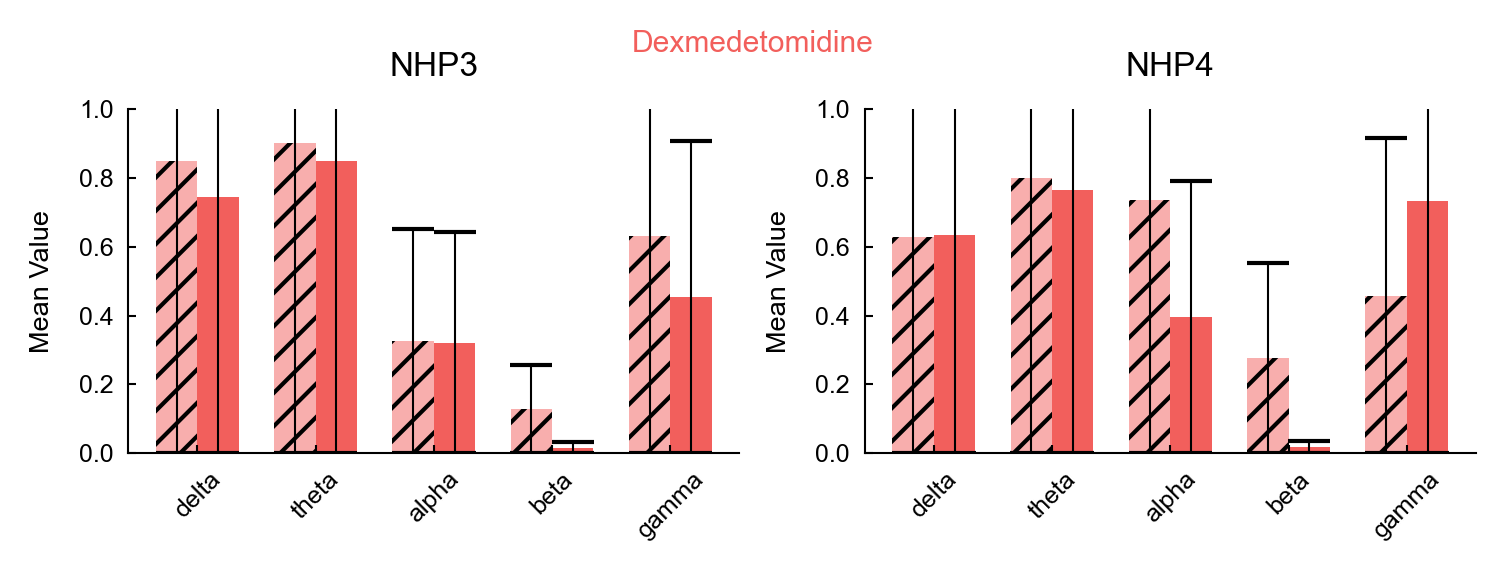

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2))
axes = [ax1, ax2]
monkey_titles = {
    'Mary': 'NHP1',
    'MrJones': 'NHP2',
    'SPOCK': 'NHP3',
    'PEDRI': 'NHP4'
}
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
x = np.arange(len(bands))
width = 0.35

# Colors for each frequency band
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
colors = curve_colors[agent]

data_dict = plot_info[(data_class, agent)]

monkeys = list(data_dict.keys())
doses = list(data_dict[monkeys[0]].keys())

# Process and plot data for each monkey
for idx, monkey in enumerate(monkeys):
    ax = axes[idx]
    
    for dose_idx, dose in enumerate(doses):
        means = []
        sems = []
        
        # Calculate mean and SEM for each frequency band
        for band in bands:
            data = data_dict[monkey][dose][band]
            mean = np.mean(data)
            sem = np.std(data) / np.sqrt(len(data))
            means.append(mean)
            sems.append(mean)
        
        # Create the bar plot with different styles for low/high doses
        # Offset the x positions for low vs high dose
        x_pos = x - width/2 if dose == 'low' else x + width/2
        if dose == 'low':
            bars = ax.bar(x_pos, means, width, yerr=sems, capsize=5, color=colors,
                         alpha=0.5, hatch='///', label='Low dose')
        else:
            bars = ax.bar(x_pos, means, width, yerr=sems, capsize=5, color=colors,
                         label='High dose')
        
    # Customize the plot
    ax.set_ylabel('Mean Value')
    ax.set_title(monkey_titles[monkey])
    ax.set_xticks(x)
    ax.set_xticklabels(bands, rotation=45)
    ax.set_ylim(0, 1)

# # Create empty patches for legend
# patch1 = plt.Rectangle((0,0), 1, 1, color=colors, alpha=0.5, hatch='///', label='Low dose')
# patch2 = plt.Rectangle((0,0), 1, 1, color=colors, label='High dose')
# # Add legend centered below all subplots
# fig.legend(handles=[patch1, patch2], loc='center', bbox_to_anchor=(0.5, 0), ncol=2)

# Adjust layout and display
fig.suptitle(f'{agent.capitalize()}', c=curve_colors[agent], y=0.9)
plt.tight_layout()
plt.show()

In [30]:
for monkey, dose in itertools.product(monkeys, doses):
    print(monkey, dose)

Mary high
MrJones high
